In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import imghdr

dir = "dataset/training"

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in os.listdir(dir):  
    class_path = os.path.join(dir, class_name)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        if imghdr.what(img_path) not in ['jpeg', 'png', 'jpg']:  # Verifica se é uma imagem
            print(f"Arquivo não suportado ou corrompido: {img_name}")
            continue
    
        try:
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            
            count = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_path, save_prefix=f"aug_{img_name.split('.')[0]}", save_format="jpg"):
                count += 1
                if count >= 2: 
                    break
        except Exception as e:
            print(f"Erro ao carregar {img_name}: {e}")
            continue

In [3]:

train_data = tf.keras.utils.image_dataset_from_directory(
    'dataset/training',
    validation_split=0.15,  
    subset="training",     
    seed=42,               
    image_size=(128, 128),
    shuffle=True, 
    batch_size=32          
)



Found 8005 images belonging to 2 classes.


In [4]:

valid_data = tf.keras.utils.image_dataset_from_directory(
    'dataset/training',
    validation_split=0.1,  
    subset="validation",   
    seed=42,               
    image_size=(128, 128), 
    batch_size=32          
)


Found 8005 files belonging to 2 classes.
Using 800 files for validation.


In [5]:
data_iterator = train_data.as_numpy_iterator()
images, labels = data_iterator.next()


In [5]:
def normalizer(image, label):
    aux = tf.cast(image, dtype=tf.float32)
    image_norm = aux/255.0
    return image_norm, label

train = train_data.map(normalizer) 
valid = valid_data.map(normalizer) 
    

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

c:\Users\Bernardo Duarte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
#model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,121 (10.60 MB)

 Trainable params: 2,779,121 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience=2,
    factor=0.5,
    min_lr = 0.00001,
    verbose = 1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose= 0)

In [9]:
hist = model.fit(
    train_data,
    validation_data=valid_data, 
    epochs=30,  
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping,learning_rate_reduction],
    verbose = 1
)



c:\Users\Bernardo Duarte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 170s 662ms/step - accuracy: 0.4999 - loss: 0.7070 - val_accuracy: 0.5625 - val_loss: 0.6826
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 167s 666ms/step - accuracy: 0.5757 - loss: 0.6712 - val_accuracy: 0.6425 - val_loss: 0.6447
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 168s 669ms/step - accuracy: 0.6249 - loss: 0.6437 - val_accuracy: 0.6463 - val_loss: 0.6301
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 644ms/step - accuracy: 0.6563 - loss: 0.6230 - val_accuracy: 0.7063 - val_loss: 0.5606
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 168s 670ms/step - accuracy: 0.6933 - loss: 0.5848 - val_accuracy: 0.7262 - val_loss: 0.5306
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 644ms/step - accuracy: 0.7000 - loss: 0.5772 - val_accuracy: 0.7350 - val_loss: 0.5157
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 169s 675ms/step - accuracy: 0.7024 - loss: 0.5626 - val_accuracy: 0.7538 - val_loss: 0.4932
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 169s 672ms/step - accuracy: 0.7151 -

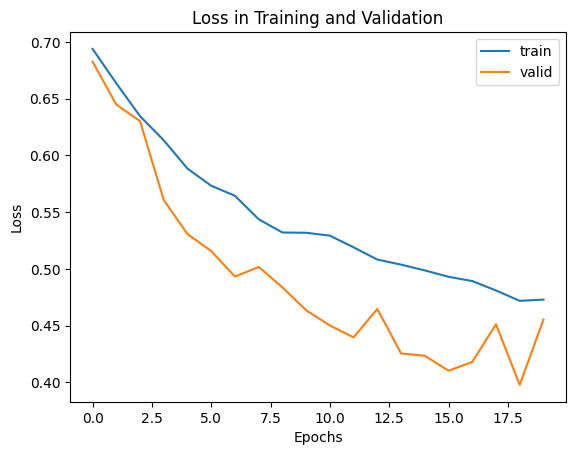

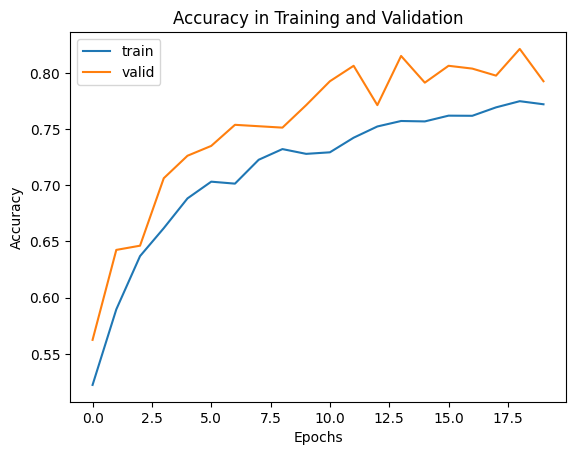

In [10]:
import matplotlib.pyplot as plt


plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss in Training and Validation')
plt.show()


if 'accuracy' in hist.history: 
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='valid')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy in Training and Validation')
    plt.show()